In [30]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/capstone22/WildFIrePrediction/PwC-LSTM-Capstone-Project/src/')
from roc import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


Data Loading

In [31]:
df_train = pd.read_csv('/home/capstone22/WildFIrePrediction/Isaac_data/isaac_train.csv')
df_valid = pd.read_csv('/home/capstone22/WildFIrePrediction/Isaac_data/isaac_valid.csv')
df_test = pd.read_csv('/home/capstone22/WildFIrePrediction/Isaac_data/isaac_test.csv')

Feature Selection

In [32]:
# selected_features = ['Road_Dist',
#                      'Elec_Dist',
#                      'Cultivated_Prop',
#                      'aet__maximum_Normal',
#                      'aet__mean_Normal',
#                      'aet__minimum_Normal',
#                      'cwd__maximum_Normal',
#                      'cwd__mean_Normal',
#                      'cwd__minimum_Normal',
#                      'pck__maximum_Normal',
#                      'pck__mean_Normal',
#                      'pck__minimum_Normal',
#                      'aet__mean_ThreeYear_Dev',
#                      'cwd__mean_ThreeYear_Dev',
#                      'Mean_Housing_Dens_25km']

selected_features = ['Road_Dist',
                    'Elec_Dist',
                    'aet__mean_Normal',
                    'aet__mean_ThreeYear_Dev',
                    'cwd__mean_Normal',
                    'cwd__mean_ThreeYear_Dev',
                    'Mean_Housing_Dens_25km',
                    'FFWI',
                    'time_since_fire']


Model

In [33]:
X_train = df_train[selected_features]
X_train_norm = preprocessing.normalize(X_train, axis = 0)
y_train = df_train['value']

X_valid = df_valid[selected_features]
X_valid_norm = preprocessing.normalize(X_valid, axis = 0)
y_valid = df_valid['value']

X_test = df_test[selected_features]
X_test_norm = preprocessing.normalize(X_test, axis = 0)
y_test = df_test['value']

In [34]:
clf = LogisticRegression().fit(X_train, y_train)

In [35]:
y_pred = clf.predict(X_valid)
y_pred_prob = clf.predict_proba(X_valid)
print(y_pred_prob)

[[0.99512887 0.00487113]
 [0.99514551 0.00485449]
 [0.99516469 0.00483531]
 ...
 [0.99513357 0.00486643]
 [0.99512913 0.00487087]
 [0.99514589 0.00485411]]


0.99215
AUC score: 0.5


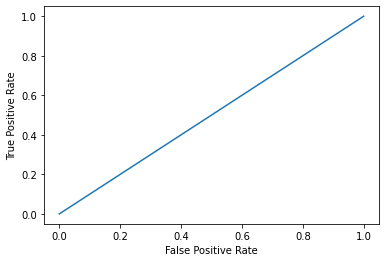

In [36]:
print(accuracy_score(y_valid, y_pred))
plot_roc_curve(y_valid, y_pred)